In [1]:
import pickle
import numpy as np
import pandas as pd
import torch
from torch import nn
import random
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import scipy
import yfinance as yf
from empyrical import sharpe_ratio
from src.features import DeepMomentumFeatures, MACDFeatures, DatetimeFeatures, DefaultFeatureCreator
from src.utils import MultivariateTrainValTestSplitter
from src.models import *

In [2]:
torch.__version__

'2.0.0'

In [3]:
with open('sectors_dict.pickle', 'rb') as f:
    sectors = pickle.load(f)

In [4]:
SEED = 42
N_ASSETS_PER_SECTOR = 5
LENGTH_THRESHOLD = 3000
DATASET_DIRNAME = 'yf_data'
USE_ADJUSTED_CLOSE = True

In [5]:
np.random.seed(SEED)
all_dfs = []
all_used_assets = []
for current_sector in sectors.keys():
    dfs = []
    assets = []
    for asset in sectors[current_sector]:
        df = pd.read_csv(os.path.join(DATASET_DIRNAME, f'{current_sector}', f'{asset}.csv'))
        # use only stocks with long enough history
        if len(df) > LENGTH_THRESHOLD:
            df['Date'] = pd.to_datetime(df['Date'])
            
            close_col = 'Adj Close' if USE_ADJUSTED_CLOSE else 'Close'
            
            cols = ['Date', 'Open', 'High', 'Low', close_col, 'Volume']
            
            df = df[cols]
            
            df.columns = ['Date'] + ['{}_{}'.format(asset, name) for name in \
                                     ['open', 'high', 'low', 'close', 'volume']]
            dfs.append(df)
            assets.append(asset)

    df = dfs[0]
    for i in range(1, len(dfs)):
        df = pd.merge(df, dfs[i], left_on='Date', right_on='Date', how='inner')

    used_assets = np.random.choice(assets, N_ASSETS_PER_SECTOR, replace=False)
    df = df[['Date'] + [name for name in df.columns[1:] if name.split('_')[0] in used_assets]]
    all_dfs.append(df)
    all_used_assets.extend(list(used_assets))

df = all_dfs[0]
for i in range(1, len(all_dfs)):
    df = pd.merge(df, all_dfs[i], left_on='Date', right_on='Date', how='inner')
df = df.set_index(df['Date'])
print('loaded dataframe shape', df.shape)

loaded dataframe shape (3068, 276)


In [6]:
df

,Date,ATVI_open,ATVI_high,ATVI_low,ATVI_close,ATVI_volume,GOOGL_open,GOOGL_high,GOOGL_low,GOOGL_close,...,SRE_open,SRE_high,SRE_low,SRE_close,SRE_volume,XEL_open,XEL_high,XEL_low,XEL_close,XEL_volume
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-24,2011-06-24,11.490000,11.490000,11.250000,10.189775,16441800,12.029029,12.030781,11.837337,11.883884,...,26.000000,26.195000,25.885000,12.255710,3270600,23.969999,24.180000,23.969999,16.178503,2162800
2011-06-27,2011-06-27,11.270000,11.490000,11.210000,10.271007,4798600,11.861862,12.222222,11.851852,12.082082,...,25.969999,26.195000,25.959999,12.338344,2036000,24.120001,24.290001,24.100000,16.306477,1412500
2011-06-28,2011-06-28,11.390000,11.600000,11.330000,10.460541,6695400,12.112613,12.417668,12.112613,12.353604,...,26.190001,26.235001,26.010000,12.293487,2512800,24.320000,24.459999,24.190001,16.420980,1720100
2011-06-29,2011-06-29,11.620000,11.760000,11.500000,10.550797,6435300,12.425926,12.518769,12.321822,12.451702,...,26.139999,26.205000,25.985001,12.347787,2127600,24.459999,24.459999,24.350000,16.420980,2013700
2011-06-30,2011-06-30,11.740000,11.790000,11.670000,10.541772,6501800,12.562312,12.679429,12.550050,12.672172,...,26.260000,26.459999,26.049999,12.484720,2234200,24.469999,24.469999,24.230000,16.367092,4290900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-28,2023-08-28,91.809998,92.010002,91.750000,91.769997,5527200,131.309998,132.539993,130.139999,131.009995,...,71.660004,72.080002,71.330002,71.559998,1600500,57.860001,58.150002,57.650002,57.849998,3982200
2023-08-29,2023-08-29,91.750000,92.099998,91.750000,91.980003,5667900,132.240005,136.570007,132.240005,134.570007,...,71.739998,72.089996,71.199997,71.709999,1777400,57.779999,58.340000,57.509998,57.950001,4614900
2023-08-30,2023-08-30,91.879997,92.040001,91.750000,91.980003,5359700,134.779999,136.279999,134.070007,135.880005,...,71.510002,71.820000,70.580002,70.849998,1938700,57.880001,58.240002,57.419998,57.680000,2583500


In [7]:
USE_DATETIME_FEATURES = False

In [8]:
used_features = [DeepMomentumFeatures, MACDFeatures]
features_configs = [{}, {}]
if USE_DATETIME_FEATURES:
    used_features.append(DatetimeFeatures)
    features_configs.append({})

fc = DefaultFeatureCreator(df, all_used_assets, used_features, features_configs)

features = fc.create_features()


In [9]:
BAD_VALUES_THRESHOLD = 10000
for key in features.keys():
    assert features[key].isnull().sum().sum() == 0
    assert features[key].max().max() < BAD_VALUES_THRESHOLD
    assert features[key].min().min() > -BAD_VALUES_THRESHOLD

In [10]:
cols_to_use = ['norm_daily_return',
               'norm_monthly_return',
               'norm_quarterly_return',
               'norm_biannual_return',
               'norm_annual_return',
               'macd_8_24',
               'macd_16_48',
               'macd_32_96']

if USE_DATETIME_FEATURES:
    datetime_cols = ['day_of_week', 'day_of_month', 'month_of_year']
else:
    datetime_cols = []

In [11]:
MODEL_MAPPING = {'lstm': LSTMnet,
                 'slp': SLP,
                 'mlp': MLP,
                 'conv': TCN,}

In [17]:
scaling = None #'standard', 'minmax'
history_size = 21
val_delta = pd.Timedelta('365days')
test_delta = pd.Timedelta('365days')
date_range = pd.date_range('2017-01-01', '2023-12-31', freq='365d')
model_type = 'mlp' 
model_params = {}
apply_turnover_reg = False
apply_l1_reg = True
weight_decay = 1e-5
lr = 1e-3
decay_steps = 10
decay_gamma = 0.75
early_stopping_rounds = 30
n_epochs = 200
device = 'cpu'
target_vol = 0.15 #measure for turnover evaluation
basis_points = [0, 1, 5, 10] #coefficients for turnover evaluation

ERROR! Session/line number was not unique in database. History logging moved to new session 1263


In [18]:
def _set_seed(seed):

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [19]:
def sharpe_loss(preds, returns, weights=None):
    R = preds*returns

    R_sum = torch.mean(R, dim=(1, 0))
    R_sum_sq = R_sum**2
    R_sq_sum = torch.mean(R**2, dim=(1, 0))
    
    sharpe = -1*252**0.5*R_sum/torch.sqrt(R_sq_sum - R_sum_sq + 1e-9)
    
    if weights is None:
        sharpe = sharpe * 1/returns.shape[2]
    else:
        raise NotImplementedError

    sharpe = torch.sum(sharpe)
    
    return sharpe

In [20]:
def reg_turnover(preds, vol, alpha=1e-4, is_l1=True, target_vol=0.15, C=5):
    vol = vol*252**0.5
    y = preds/(vol + 1e-12)
    y = torch.diff(y, dim=1)
    
    if is_l1:
        y = torch.abs(y)
    else:
        y = y**2
        
        
    l = alpha*C*target_vol*torch.mean(y)    
    
    return l

In [21]:
def reg_l1(model, alpha=1e-4):
    l = 0
    for p in model.parameters():
        l += torch.mean(torch.abs(p))
    
    l = alpha*l
    
    return l

Random seed set as 42


  0%|          | 0/200 [00:00<?, ?it/s]

Iter:  0
Train loss:  -0.399
Val loss:  -0.825
Validation Sharpe Ratio
C:  0 SR:  1.585
C:  1 SR:  1.562
C:  5 SR:  1.47
C:  10 SR:  1.355
L1 loss 0.0
Epochs till end:  29

Iter:  1
Train loss:  -1.624
Val loss:  -0.957
Validation Sharpe Ratio
C:  0 SR:  2.165
C:  1 SR:  2.108
C:  5 SR:  1.879
C:  10 SR:  1.593
L1 loss 0.0
Epochs till end:  30

Iter:  2
Train loss:  -2.295
Val loss:  -1.299
Validation Sharpe Ratio
C:  0 SR:  1.082
C:  1 SR:  1.015
C:  5 SR:  0.744
C:  10 SR:  0.405
L1 loss 0.0
Epochs till end:  29

Iter:  3
Train loss:  -3.278
Val loss:  -2.114
Validation Sharpe Ratio
C:  0 SR:  1.119
C:  1 SR:  1.033
C:  5 SR:  0.688
C:  10 SR:  0.257
L1 loss 0.0
Epochs till end:  28

Iter:  4
Train loss:  -5.202
Val loss:  -3.528
Validation Sharpe Ratio
C:  0 SR:  -0.461
C:  1 SR:  -0.676
C:  5 SR:  -1.534
C:  10 SR:  -2.604
L1 loss 0.0
Epochs till end:  27

Iter:  5
Train loss:  -6.829
Val loss:  -4.155
Validation Sharpe Ratio
C:  0 SR:  -2.141
C:  1 SR:  -2.386
C:  5 SR:  -3.367
C:

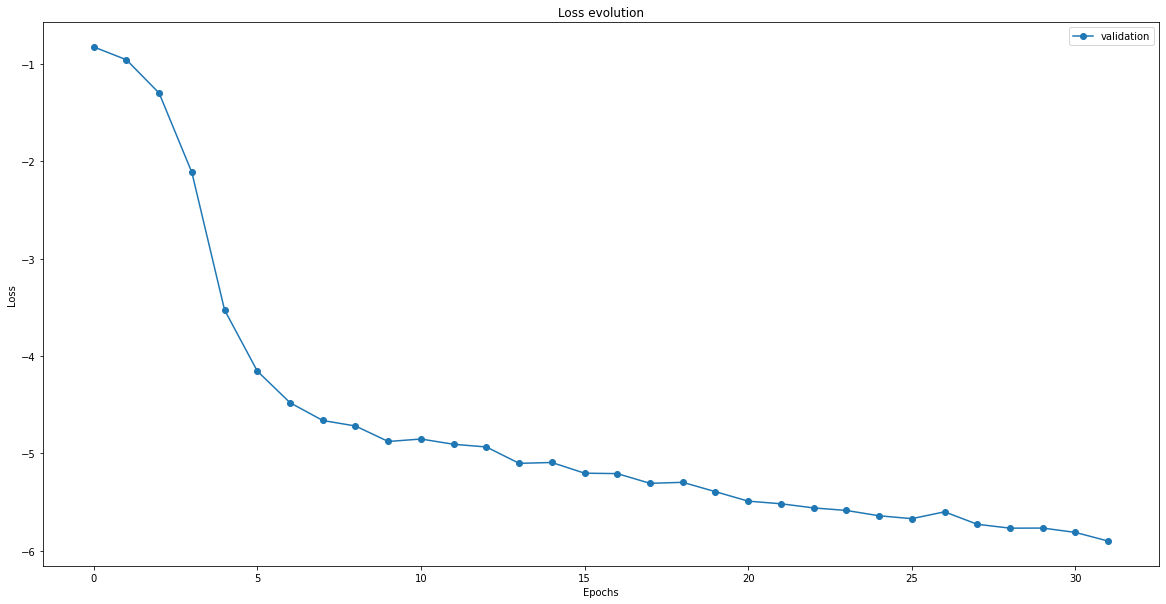

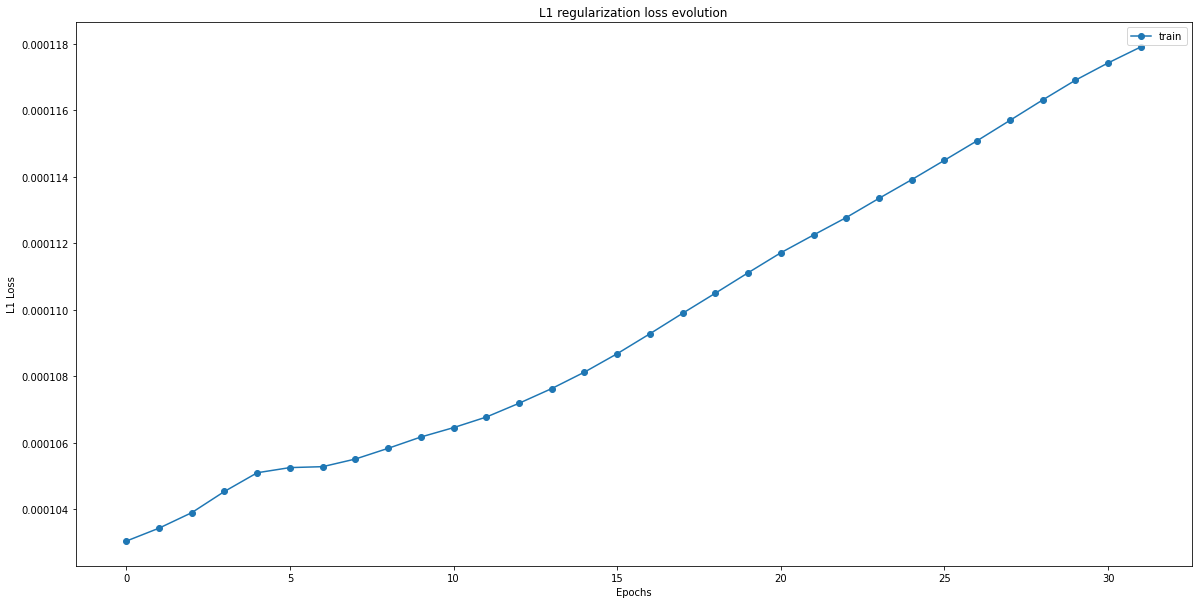

Random seed set as 42


  0%|          | 0/200 [00:00<?, ?it/s]

Iter:  0
Train loss:  -0.498
Val loss:  -1.176
Validation Sharpe Ratio
C:  0 SR:  1.195
C:  1 SR:  1.168
C:  5 SR:  1.06
C:  10 SR:  0.925
L1 loss 0.0
Epochs till end:  29

Iter:  1
Train loss:  -1.679
Val loss:  -1.411
Validation Sharpe Ratio
C:  0 SR:  0.924
C:  1 SR:  0.893
C:  5 SR:  0.771
C:  10 SR:  0.619
L1 loss 0.0
Epochs till end:  30

Iter:  2
Train loss:  -2.391
Val loss:  -2.035
Validation Sharpe Ratio
C:  0 SR:  0.751
C:  1 SR:  0.725
C:  5 SR:  0.622
C:  10 SR:  0.493
L1 loss 0.0
Epochs till end:  29

Iter:  3
Train loss:  -3.787
Val loss:  -3.986
Validation Sharpe Ratio
C:  0 SR:  0.452
C:  1 SR:  0.399
C:  5 SR:  0.19
C:  10 SR:  -0.071
L1 loss 0.0
Epochs till end:  28

Iter:  4
Train loss:  -5.831
Val loss:  -5.618
Validation Sharpe Ratio
C:  0 SR:  0.67
C:  1 SR:  0.589
C:  5 SR:  0.265
C:  10 SR:  -0.141
L1 loss 0.0
Epochs till end:  27

Iter:  5
Train loss:  -6.998
Val loss:  -6.203
Validation Sharpe Ratio
C:  0 SR:  0.85
C:  1 SR:  0.747
C:  5 SR:  0.337
C:  10 SR:

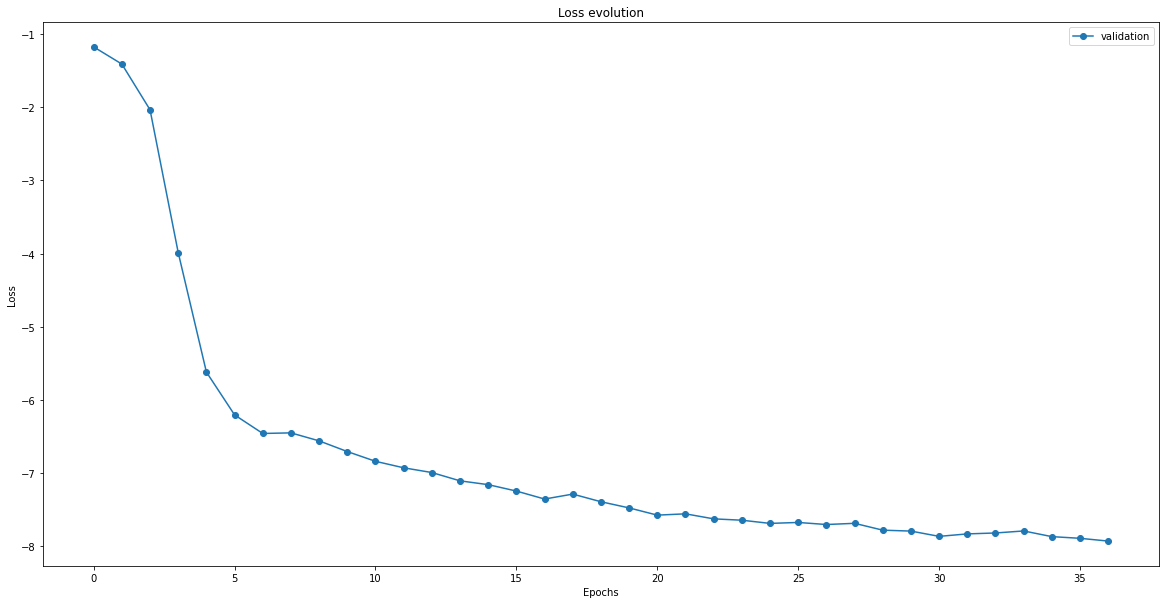

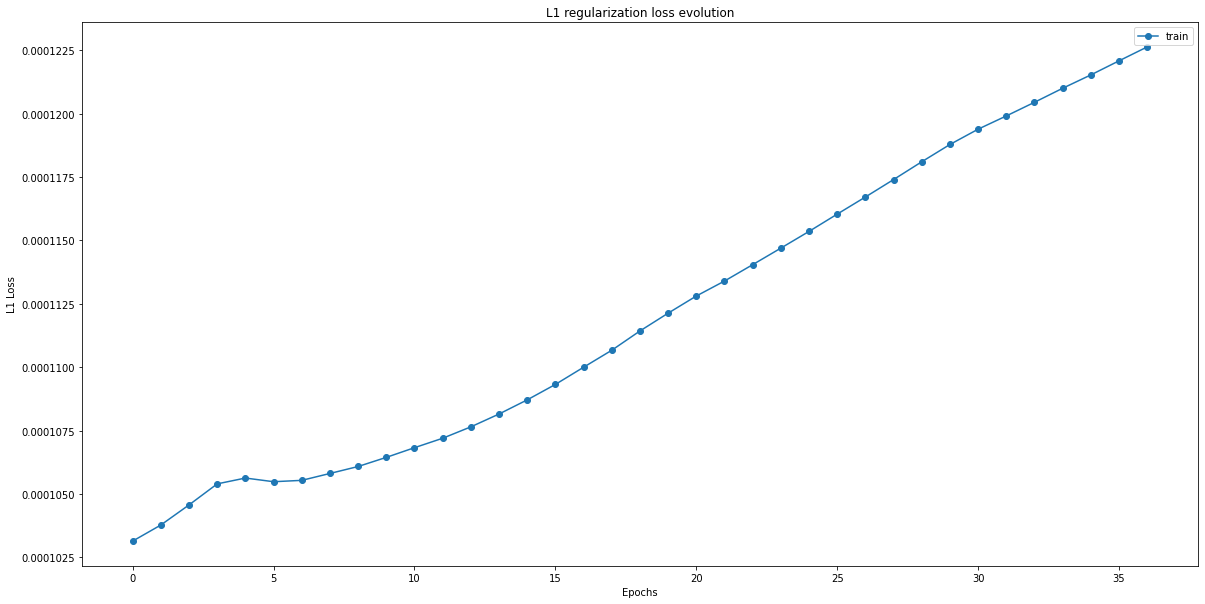

Random seed set as 42


  0%|          | 0/200 [00:00<?, ?it/s]

Iter:  0
Train loss:  -0.535
Val loss:  -1.008
Validation Sharpe Ratio
C:  0 SR:  -2.091
C:  1 SR:  -2.128
C:  5 SR:  -2.279
C:  10 SR:  -2.467
L1 loss 0.0
Epochs till end:  29

Iter:  1
Train loss:  -1.689
Val loss:  -1.769
Validation Sharpe Ratio
C:  0 SR:  -0.518
C:  1 SR:  -0.555
C:  5 SR:  -0.703
C:  10 SR:  -0.888
L1 loss 0.0
Epochs till end:  30

Iter:  2
Train loss:  -2.605
Val loss:  -2.952
Validation Sharpe Ratio
C:  0 SR:  0.783
C:  1 SR:  0.722
C:  5 SR:  0.478
C:  10 SR:  0.172
L1 loss 0.0
Epochs till end:  30

Iter:  3
Train loss:  -4.636
Val loss:  -5.087
Validation Sharpe Ratio
C:  0 SR:  0.919
C:  1 SR:  0.753
C:  5 SR:  0.093
C:  10 SR:  -0.732
L1 loss 0.0
Epochs till end:  30

Iter:  4
Train loss:  -6.462
Val loss:  -6.067
Validation Sharpe Ratio
C:  0 SR:  2.338
C:  1 SR:  2.103
C:  5 SR:  1.161
C:  10 SR:  -0.015
L1 loss 0.0
Epochs till end:  30

Iter:  5
Train loss:  -7.246
Val loss:  -6.33
Validation Sharpe Ratio
C:  0 SR:  1.257
C:  1 SR:  1.031
C:  5 SR:  0.128

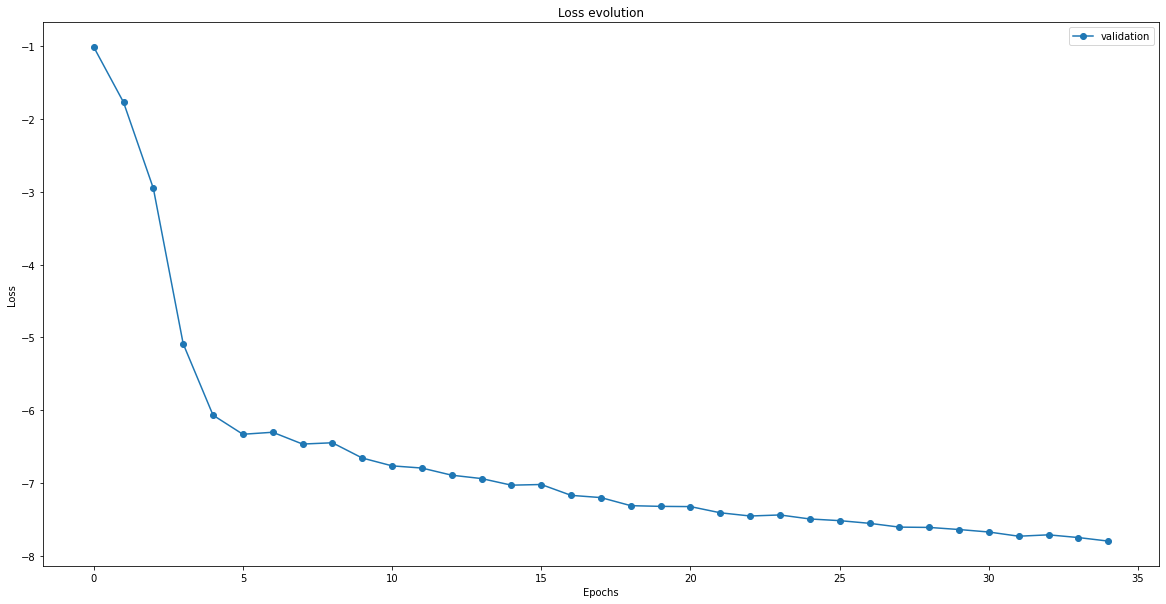

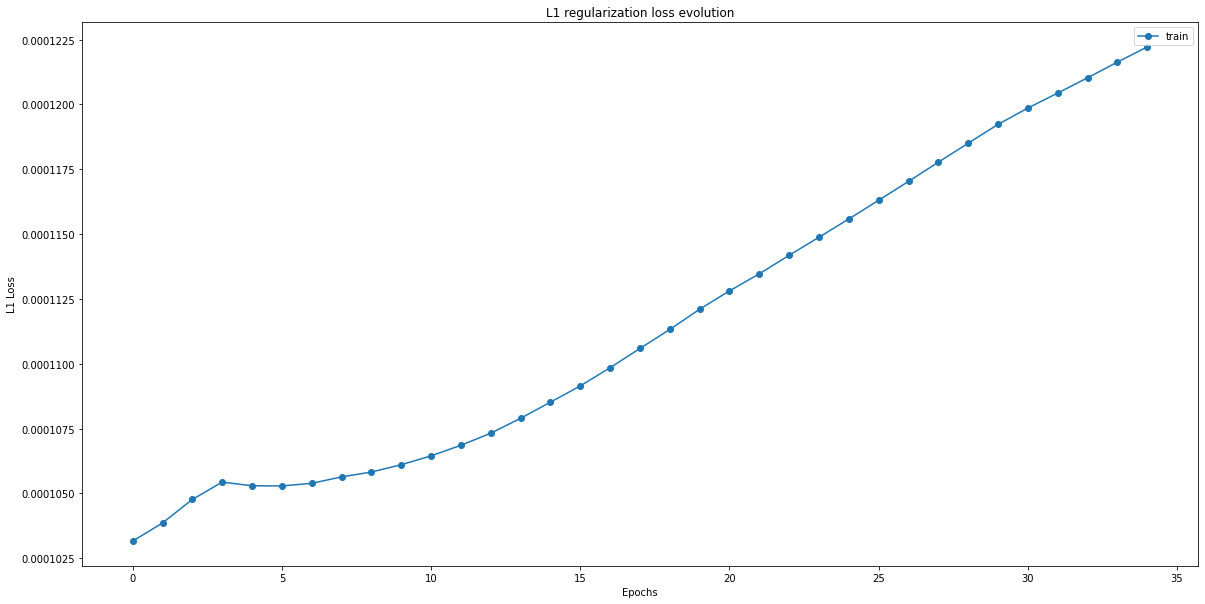

Random seed set as 42


  0%|          | 0/200 [00:00<?, ?it/s]

Iter:  0
Train loss:  -0.581
Val loss:  -1.443
Validation Sharpe Ratio
C:  0 SR:  0.703
C:  1 SR:  0.681
C:  5 SR:  0.595
C:  10 SR:  0.488
L1 loss 0.0
Epochs till end:  29

Iter:  1
Train loss:  -1.883
Val loss:  -2.562
Validation Sharpe Ratio
C:  0 SR:  0.442
C:  1 SR:  0.409
C:  5 SR:  0.278
C:  10 SR:  0.114
L1 loss 0.0
Epochs till end:  30

Iter:  2
Train loss:  -3.234
Val loss:  -5.032
Validation Sharpe Ratio
C:  0 SR:  1.022
C:  1 SR:  0.984
C:  5 SR:  0.832
C:  10 SR:  0.642
L1 loss 0.0
Epochs till end:  30

Iter:  3
Train loss:  -5.67
Val loss:  -7.394
Validation Sharpe Ratio
C:  0 SR:  0.307
C:  1 SR:  0.215
C:  5 SR:  -0.153
C:  10 SR:  -0.613
L1 loss 0.0
Epochs till end:  29

Iter:  4
Train loss:  -6.849
Val loss:  -7.902
Validation Sharpe Ratio
C:  0 SR:  -0.115
C:  1 SR:  -0.197
C:  5 SR:  -0.523
C:  10 SR:  -0.931
L1 loss 0.0
Epochs till end:  28

Iter:  5
Train loss:  -7.428
Val loss:  -8.056
Validation Sharpe Ratio
C:  0 SR:  0.337
C:  1 SR:  0.27
C:  5 SR:  -0.001
C: 

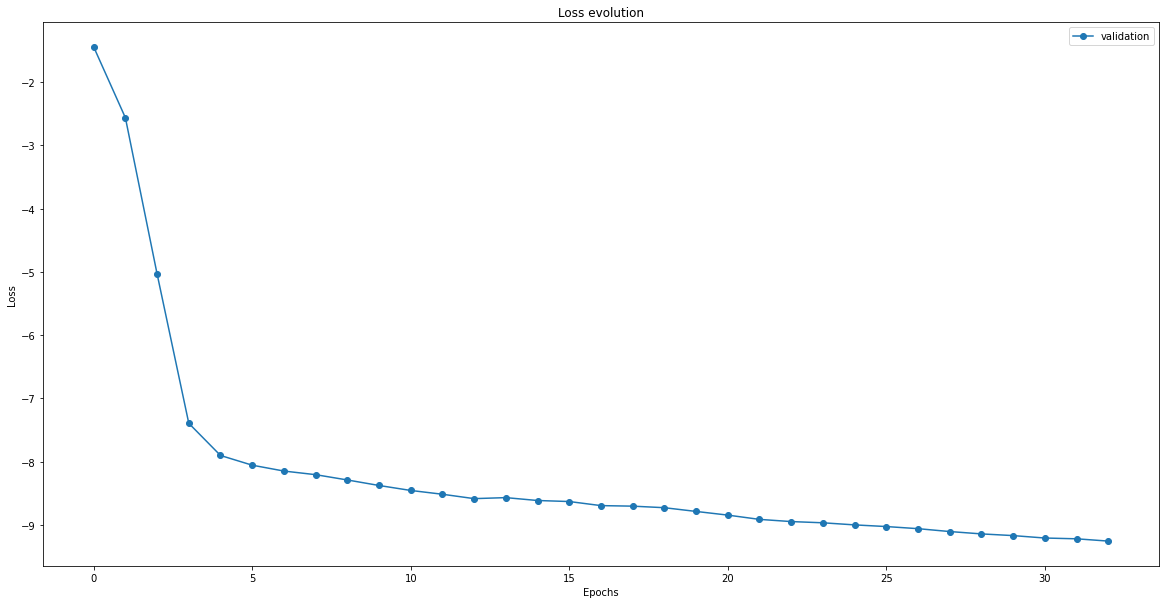

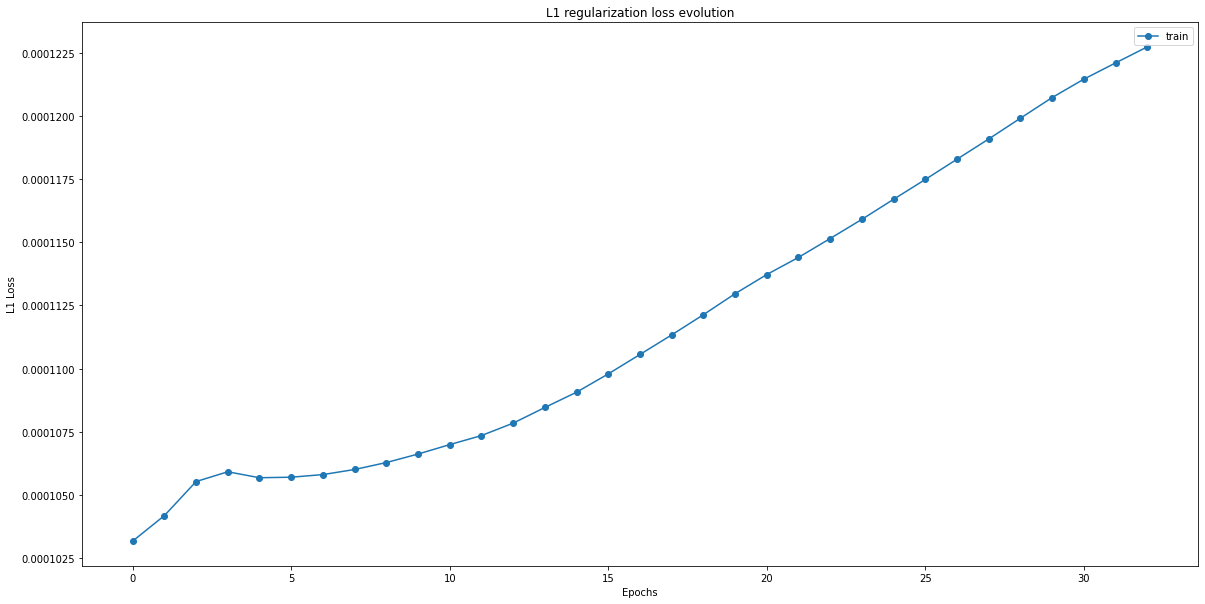

Random seed set as 42


  0%|          | 0/200 [00:00<?, ?it/s]

Iter:  0
Train loss:  -0.798
Val loss:  -1.17
Validation Sharpe Ratio
C:  0 SR:  0.79
C:  1 SR:  0.75
C:  5 SR:  0.593
C:  10 SR:  0.397
L1 loss 0.0
Epochs till end:  29

Iter:  1
Train loss:  -2.218
Val loss:  -2.329
Validation Sharpe Ratio
C:  0 SR:  1.363
C:  1 SR:  1.282
C:  5 SR:  0.959
C:  10 SR:  0.554
L1 loss 0.0
Epochs till end:  30

Iter:  2
Train loss:  -4.308
Val loss:  -5.01
Validation Sharpe Ratio
C:  0 SR:  -1.085
C:  1 SR:  -1.236
C:  5 SR:  -1.842
C:  10 SR:  -2.6
L1 loss 0.0
Epochs till end:  29

Iter:  3
Train loss:  -6.443
Val loss:  -5.961
Validation Sharpe Ratio
C:  0 SR:  -0.616
C:  1 SR:  -0.805
C:  5 SR:  -1.56
C:  10 SR:  -2.504
L1 loss 0.0
Epochs till end:  28

Iter:  4
Train loss:  -7.233
Val loss:  -6.23
Validation Sharpe Ratio
C:  0 SR:  -0.899
C:  1 SR:  -1.121
C:  5 SR:  -2.008
C:  10 SR:  -3.116
L1 loss 0.0
Epochs till end:  27

Iter:  5
Train loss:  -7.608
Val loss:  -6.32
Validation Sharpe Ratio
C:  0 SR:  0.266
C:  1 SR:  0.062
C:  5 SR:  -0.756
C:  

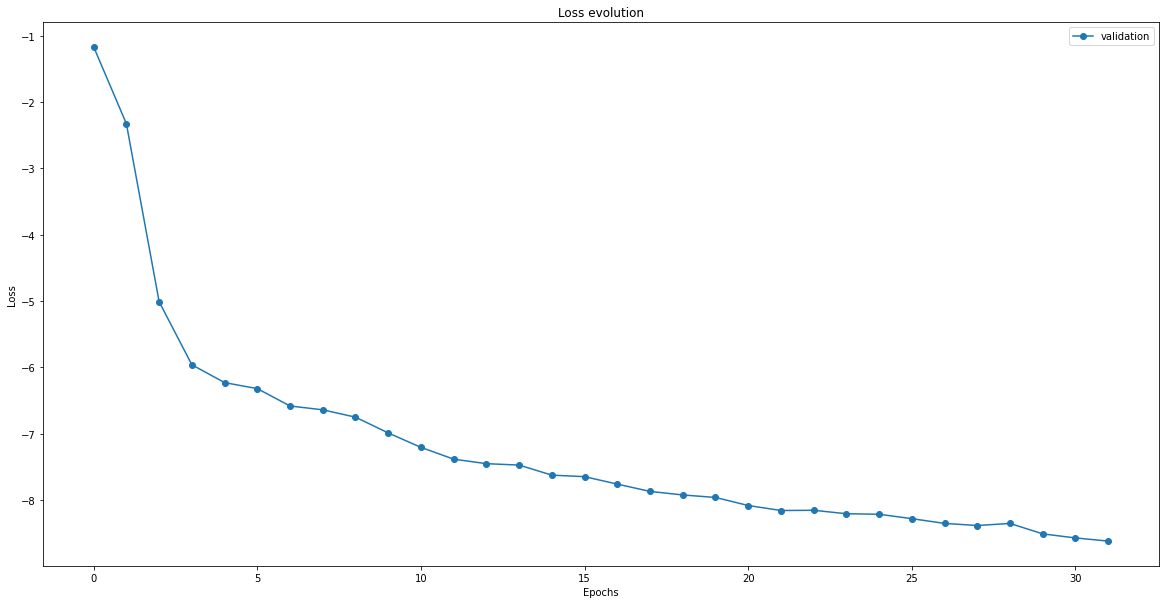

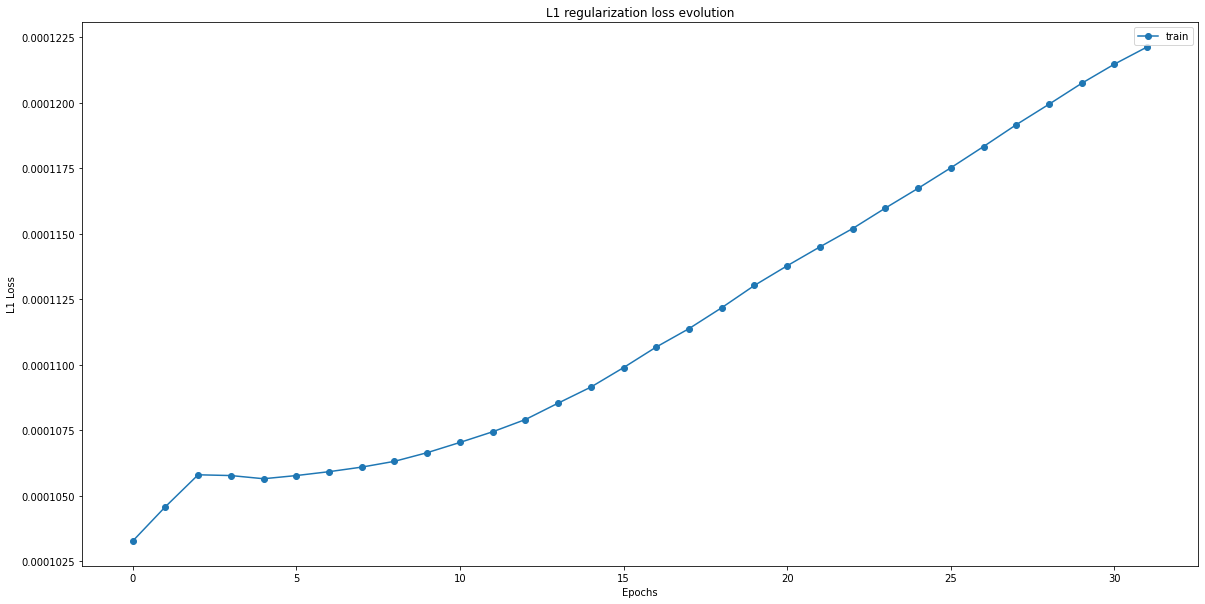

Random seed set as 42


  0%|          | 0/200 [00:00<?, ?it/s]

Iter:  0
Train loss:  -0.745
Val loss:  -1.511
Validation Sharpe Ratio
C:  0 SR:  -0.36
C:  1 SR:  -0.38
C:  5 SR:  -0.461
C:  10 SR:  -0.562
L1 loss 0.0
Epochs till end:  29

Iter:  1
Train loss:  -2.395
Val loss:  -3.696
Validation Sharpe Ratio
C:  0 SR:  0.241
C:  1 SR:  0.22
C:  5 SR:  0.135
C:  10 SR:  0.029
L1 loss 0.0
Epochs till end:  30

Iter:  2
Train loss:  -4.938
Val loss:  -7.355
Validation Sharpe Ratio
C:  0 SR:  0.231
C:  1 SR:  0.187
C:  5 SR:  0.012
C:  10 SR:  -0.207
L1 loss 0.0
Epochs till end:  29

Iter:  3
Train loss:  -6.664
Val loss:  -8.403
Validation Sharpe Ratio
C:  0 SR:  0.339
C:  1 SR:  0.294
C:  5 SR:  0.115
C:  10 SR:  -0.108
L1 loss 0.0
Epochs till end:  30

Iter:  4
Train loss:  -7.303
Val loss:  -8.599
Validation Sharpe Ratio
C:  0 SR:  0.474
C:  1 SR:  0.421
C:  5 SR:  0.209
C:  10 SR:  -0.056
L1 loss 0.0
Epochs till end:  30

Iter:  5
Train loss:  -7.583
Val loss:  -8.77
Validation Sharpe Ratio
C:  0 SR:  0.804
C:  1 SR:  0.758
C:  5 SR:  0.573
C:  1

Iter:  47
Train loss:  -13.017
Val loss:  -10.602
Validation Sharpe Ratio
C:  0 SR:  1.455
C:  1 SR:  1.396
C:  5 SR:  1.163
C:  10 SR:  0.872
L1 loss 0.0
Epochs till end:  0

Validation dates:  2021-12-31 00:00:00 2022-12-31 00:00:00


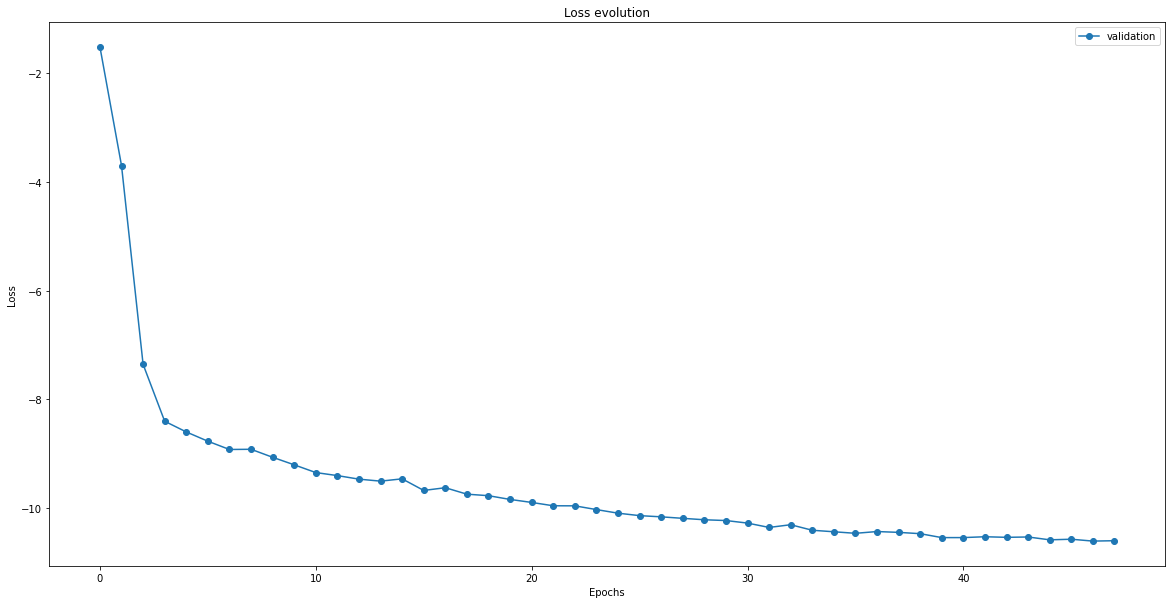

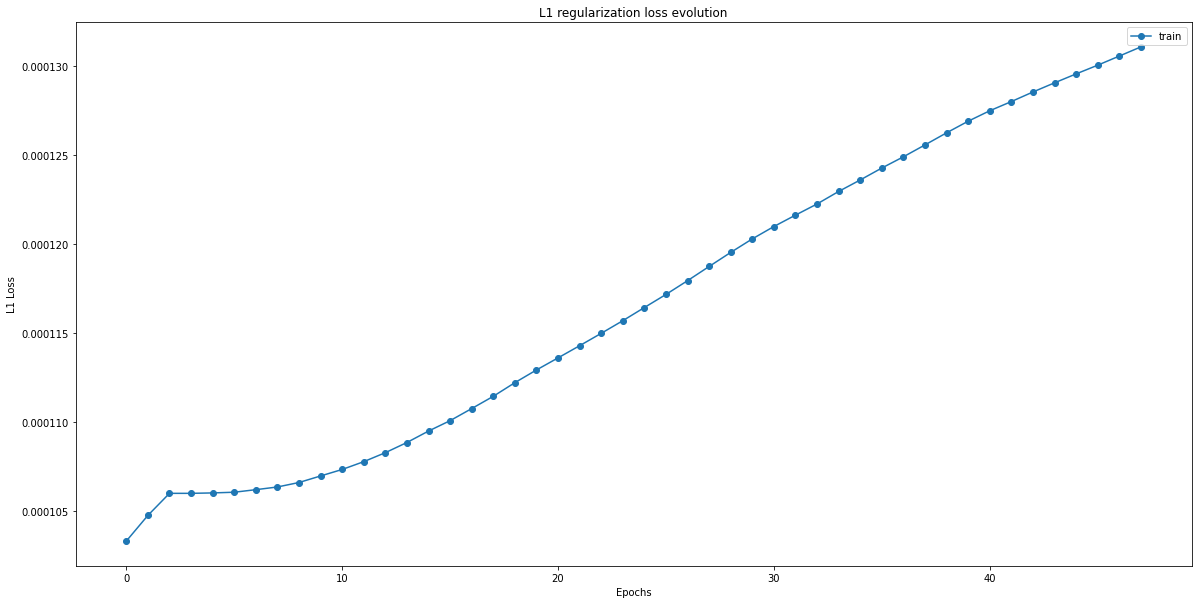

In [22]:
for seed in [42]:
    
    if not os.path.exists('weights'):
        os.mkdir('weights')
    if not os.path.exists('results'):
        os.mkidr('results')
    
    test_dts = []
    results = {}
    splitter = MultivariateTrainValTestSplitter(features, cols_to_use, datetime_cols, 'target_returns', 'target_returns_nonscaled',
                                        'daily_vol', scaling=scaling, timesteps=history_size)
    for start in date_range:
        train_loader, val_loader, test_loader, test_dt = splitter.split(start, val_delta, test_delta, seed)
        test_dts.append(test_dt)
        if len(test_loader) == 0:
            continue
        
        dt = start
        results[dt] = {}
        
        batch_x, batch_y, batch_y_orig, batch_vol = next(iter(train_loader))
        
        input_dim = batch_x.shape[2]
        output_dim = batch_y.shape[2]
        timesteps = history_size
        
        _set_seed(seed)
        model = MODEL_MAPPING[model_type](input_dim, output_dim, timesteps, **model_params).to(device)
        
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        sc = torch.optim.lr_scheduler.StepLR(opt, decay_steps, decay_gamma)

        counter = 0
        
        train_losses = []
        train_l1_losses = []
        train_turnover_losses = []
        val_losses = []
        val_turnover_losses = []
        best_val_sharpe = np.NINF
        
        for e in tqdm(range(n_epochs)):
            train_loss = 0
            train_l1_loss = 0
            train_turnover_loss = 0
            model.train()
            for batch_x, batch_y, _, batch_vol in train_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                batch_vol = batch_vol.to(device)

                opt.zero_grad()

                output = model(batch_x)

                l = sharpe_loss(output, batch_y)
                train_loss += l.item()
            
                if apply_l1_reg:
                    l_l1 = reg_l1(model)
                    train_l1_loss += l_l1.item()
                    l += l_l1

                if apply_turnover_reg:
                    l_turnover = reg_turnover(output, batch_vol)
                    train_turnover_loss += l_turnover.item()
                    l += l_turnover
                
                l.backward()
                opt.step()
            
            # we do not want learning rate to be too small
            if sc.get_last_lr()[0] > 1e-5:
                sc.step()
            
            val_loss = 0
            val_turnover_loss = 0
            
            preds = []
            returns = []
            vols = []
            
            model.eval()
            
            with torch.no_grad():
                for batch_x, batch_y, _, batch_vol in val_loader:
                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device)
                    batch_vol = batch_vol.to(device)
                    
                    output = model(batch_x)
                    
                    l = sharpe_loss(output, batch_y)
                    val_loss += l.item()

                    if apply_turnover_reg:
                        l_turnover = reg_turnover(output, batch_vol)
                        val_turnover_loss += l_turnover.item()
                    
                    # select last timestep as we no longer need for time axis in batch
                    returns.append(batch_y[:, -1, :].detach().cpu().numpy())
                    preds.append(output[:, -1, :].detach().cpu().numpy())
                    vols.append(batch_vol[:, -1, :].detach().cpu().numpy())
                    
                    
            preds = np.concatenate(preds)
            returns = np.concatenate(returns)
            vols = np.concatenate(vols)
            
            #annualized volatility
            vols = vols * 252**0.5
            # validation turnover
            T = target_vol*np.abs(np.diff(preds/(vols+1e-12), prepend=0.0, axis=0))
            # validation sharpe ratios with different turnover strength
            val_sharpes = {}

            for c in basis_points:
                captured = returns*preds - 1e-4*c*T
                R = np.mean(captured, axis=1)
                sharpes = sharpe_ratio(R)
                #sharpes = [sharpe_ratio(captured[:, i]) for i in range(captured.shape[1])]
                sharpes = np.mean(sharpes)
                val_sharpes[c] = sharpes
                
            # one can use sharpe ratio averaged by all turnover coefficients as validation performance metric
            #val_sharpe = np.mean(list(val_sharpes.values()))
            
            val_sharpe = val_sharpes[0]
            
            if best_val_sharpe < val_sharpe and e > 0:
                best_val_sharpe = val_sharpe
                counter = 0
                torch.save(model.state_dict(), os.path.join('weights', '{}_seed_{}.pt'.format(model_type, seed)))
            
            else:
                counter += 1
            
            if counter > early_stopping_rounds:
                break
            
            train_loss /= len(train_loader)
            train_l1_loss/= len(train_loader)
            train_turnover_loss /= len(train_loader)
            val_loss /= len(val_loader)
            val_turnover_loss /= len(val_loader)
            
            train_losses.append(train_loss)
            train_l1_losses.append(train_l1_loss)
            train_turnover_losses.append(train_turnover_loss)
            val_losses.append(val_loss)
            val_turnover_losses.append(val_turnover_loss)
            
            print('Iter: ', e)
            print('Train loss: ', round(train_losses[-1], 3))
            print('Val loss: ', round(val_losses[-1], 3))
            print('Validation Sharpe Ratio')
            for key in val_sharpes.keys():
                print('C: ', key, 'SR: ', round(val_sharpes[key], 3))
            if apply_l1_reg:
                print('L1 loss', round(train_l1_losses[-1], 5))
            if apply_turnover_reg:
                print('Train turnover loss: ', round(train_turnover_losses[-1], 5))
                print('Val turnover loss: ', round(val_turnover_losses[-1], 5))
            print('Epochs till end: ', early_stopping_rounds - counter)
            print()
        
        print('Validation dates: ', start, start+val_delta)
        
        plt.figure(figsize=(20, 10))
        plt.title('Loss evolution')
        #plt.plot(train_losses, label='train', marker='o')
        plt.plot(val_losses, label='validation', marker='o')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()
        
        if apply_l1_reg:
            plt.figure(figsize=(20, 10))
            plt.title('L1 regularization loss evolution')
            plt.plot(train_l1_losses, label='train', marker='o')
            plt.ylabel('L1 Loss')
            plt.xlabel('Epochs')
            plt.legend()
            plt.show()
        
        if apply_turnover_reg:
            plt.figure(figsize=(20, 10))
            plt.title('Turnover loss evolution')
            plt.plot(train_turnover_losses, label='train', marker='o')
            plt.plot(val_turnover_losses, label='validation', marker='o')
            plt.ylabel('Turnover loss')
            plt.xlabel('Epochs')
            plt.legend()
            plt.show()
        
        model.load_state_dict(torch.load(os.path.join('weights', '{}_seed_{}.pt'.format(model_type, seed))))
        model = model.to(device)
        model.eval()
        
        val_preds = []
        val_returns = []
        val_returns_orig = []
        val_vols = []

        model.eval()

        with torch.no_grad():
            for batch_x, batch_y, batch_y_orig, batch_vol in val_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                batch_y_orig = batch_y_orig.to(device)
                batch_vol = batch_vol.to(device)

                output = model(batch_x)


                # select last timestep as we no longer need for time axis in batch
                val_returns.append(batch_y[:, -1, :].detach().cpu().numpy())
                val_returns_orig.append(batch_y_orig[:, -1, :].detach().cpu().numpy())
                val_preds.append(output[:, -1, :].detach().cpu().numpy())
                val_vols.append(batch_vol[:, -1, :].detach().cpu().numpy())


        val_preds = np.concatenate(val_preds)
        val_returns = np.concatenate(val_returns)
        val_returns_orig = np.concatenate(val_returns_orig)
        val_vols = np.concatenate(val_vols)
        
        test_preds = []
        test_returns = []
        test_returns_orig = []
        test_vols = []

        with torch.no_grad():
            for batch_x, batch_y, batch_y_orig, batch_vol in test_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                batch_y_orig = batch_y_orig.to(device)
                batch_vol = batch_vol.to(device)

                output = model(batch_x)


                # select last timestep as we no longer need for time axis in batch
                test_returns.append(batch_y[:, -1, :].detach().cpu().numpy())
                test_returns_orig.append(batch_y_orig[:, -1, :].detach().cpu().numpy())
                test_preds.append(output[:, -1, :].detach().cpu().numpy())
                test_vols.append(batch_vol[:, -1, :].detach().cpu().numpy())


        test_preds = np.concatenate(test_preds)
        test_returns = np.concatenate(test_returns)
        test_returns_orig = np.concatenate(test_returns_orig)
        test_vols = np.concatenate(test_vols)

        results[dt]['val'] = {}
        results[dt]['test'] = {}
        results[dt]['test_dt'] = test_dt
        
        results[dt]['val']['preds'] = val_preds
        results[dt]['val']['returns'] = val_returns
        results[dt]['val']['returns_orig'] = val_returns_orig
        results[dt]['val']['vols'] = val_vols
        
        results[dt]['test']['preds'] = test_preds
        results[dt]['test']['returns'] = test_returns
        results[dt]['test']['returns_orig'] = test_returns_orig
        results[dt]['test']['vols'] = test_vols
        
        
    with open(os.path.join('results', '{}_seed_{}_2.pickle'.format(model_type, seed)), 'wb') as f:
        pickle.dump(results, f)

In [25]:
batch_x.shape

torch.Size([64, 21, 440])

In [28]:
440*0.3

132.0

In [ ]:
T.shape

In [ ]:
captured.shape

In [ ]:
CHECK TURNOVER CALCULATION IN PAPER CODE

In [20]:
with open(os.path.join('results', '{}_seed_{}.pickle'.format(model_type, seed)), 'rb') as f:
    s = pickle.load(f)

In [21]:
s.keys()

dict_keys([Timestamp('2017-01-01 00:00:00', freq='365D'), Timestamp('2018-01-01 00:00:00', freq='365D'), Timestamp('2019-01-01 00:00:00', freq='365D'), Timestamp('2020-01-01 00:00:00', freq='365D'), Timestamp('2020-12-31 00:00:00', freq='365D'), Timestamp('2021-12-31 00:00:00', freq='365D')])

In [22]:
s

{Timestamp('2017-01-01 00:00:00', freq='365D'): {'val': {'preds': array([[-0.06719825, -0.12165906, -0.15836045, ..., -0.02192476,
           -0.05855001, -0.04660154],
          [-0.05941394, -0.09929574, -0.16683619, ..., -0.0629783 ,
           -0.06911193, -0.05740706],
          [-0.03437181, -0.10851533, -0.13773099, ..., -0.0302827 ,
           -0.07600641, -0.05329055],
          ...,
          [-0.06244482, -0.08418113,  0.01842139, ..., -0.07675992,
           -0.1257724 ,  0.00476152],
          [-0.06811493, -0.07323923,  0.00766079, ..., -0.12835382,
           -0.1904522 , -0.03424367],
          [-0.02420451, -0.09484015,  0.01929842, ..., -0.08453773,
           -0.18312718, -0.03283702]], dtype=float32),
   'returns': array([[ 0.01218061, -0.0002563 ,  0.00401444, ...,  0.00114788,
            0.00839684,  0.00594892],
          [ 0.00948089,  0.00570152, -0.01789113, ...,  0.00440326,
            0.        , -0.00164429],
          [-0.0004819 ,  0.01330482,  0.017872

In [24]:
batch_y[0]

tensor([[ 2.5797e-03,  3.7085e-04, -3.2144e-03,  ..., -8.8253e-03,
         -5.5738e-03, -7.6499e-03],
        [-4.4201e-03,  5.9013e-03,  3.8420e-03,  ...,  8.9822e-05,
          5.0745e-03, -2.9620e-03],
        [ 6.8760e-03,  7.9661e-04,  4.4505e-03,  ..., -5.1095e-03,
          2.1016e-03, -3.1893e-03],
        ...,
        [-2.2367e-03, -2.9538e-03, -1.8163e-03,  ..., -9.4694e-03,
          5.8776e-04, -4.8728e-04],
        [ 2.2782e-03, -1.4484e-02,  3.1967e-03,  ...,  4.6133e-04,
         -5.9723e-04,  1.9829e-03],
        [ 7.0853e-02,  3.3031e-03,  1.2235e-02,  ...,  1.5749e-02,
          1.2759e-02,  1.5639e-02]])

In [25]:
batch_y_orig[0]

tensor([[ 0.0045,  0.0007, -0.0058,  ..., -0.0118, -0.0065, -0.0093],
        [-0.0076,  0.0115,  0.0068,  ...,  0.0001,  0.0059, -0.0036],
        [ 0.0117,  0.0015,  0.0078,  ..., -0.0067,  0.0024, -0.0038],
        ...,
        [-0.0033, -0.0052, -0.0029,  ..., -0.0122,  0.0007, -0.0006],
        [ 0.0033, -0.0254,  0.0050,  ...,  0.0006, -0.0007,  0.0022],
        [ 0.1002,  0.0059,  0.0189,  ...,  0.0199,  0.0143,  0.0172]])

In [18]:
results['test']['preds'] = test_preds
results['test']['returns'] = test_returns
results['test']['returns_orig'] = test_returns_orig
results['test']['vols'] = test_vols

In [41]:
T

array([[0.83383634, 0.51192949, 0.28745112, ..., 0.18885391, 1.07419992,
        1.04470401],
       [0.67396717, 0.55053077, 0.53674765, ..., 0.62509811, 0.56359869,
        0.24428089],
       [0.32709056, 0.61189209, 0.3497896 , ..., 0.01410749, 0.66190774,
        0.9456643 ],
       ...,
       [0.87709293, 0.57821921, 0.4666867 , ..., 0.39466517, 0.78080213,
        0.70181444],
       [0.03822577, 0.38370012, 0.83944019, ..., 0.0178256 , 0.54594523,
        0.74240624],
       [0.57244881, 0.2677478 , 0.34134158, ..., 0.32640767, 0.57954612,
        0.71406727]])

In [36]:
batch_x, batch_y, batch_y_orig, batch_vol = next(iter(train_loader))

In [37]:
batch_x.shape, batch_vol.shape

(torch.Size([64, 21, 440]), torch.Size([64, 21, 55]))

In [38]:
batch_x.max()

tensor(5.8374)

In [39]:
batch_x.min()

tensor(-5.7343)

In [40]:
batch_y.shape, batch_y_orig.shape

(torch.Size([64, 21, 55]), torch.Size([64, 21, 55]))

In [69]:
#model = LSTMnet(batch_x.shape[2], batch_y.shape[2], batch_x.shape[1])
#model = SLP(batch_x.shape[2], batch_y.shape[2], batch_x.shape[1])
#model = MLP(batch_x.shape[2], batch_y.shape[2], batch_x.shape[1])
model = TCN(batch_x.shape[2], batch_y.shape[2], batch_x.shape[1], 5)

In [ ]:
val_preds = []
val_returns = []
val_returns_orig = []
val_vols = []

model.eval()

with torch.no_grad():
    for batch_x, batch_y, batch_y_orig, batch_vol in val_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_orig = batch_y_orig.to(device)
        batch_vol = batch_vol.to(device)

        output = model(batch_x)


        # select last timestep as we no longer need for time axis in batch
        val_returns.append(batch_y[:, -1, :].detach().cpu().numpy())
        val_returns_orig.append(batch_y[:, -1, :].detach().cpu().numpy())
        val_preds.append(output[:, -1, :].detach().cpu().numpy())
        val_vols.append(batch_vol[:, -1, :].detach().cpu().numpy())


val_preds = np.concatenate(val_preds)
val_returns = np.concatenate(val_returns)
val_returns_orig = np.concatenate(val_returns_orig)
val_vols = np.concatenate(val_vols)

In [ ]:
test_preds = []
test_returns = []
test_returns_orig = []
test_vols = []

with torch.no_grad():
    for batch_x, batch_y, batch_y_orig, batch_vol in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_orig = batch_y_orig.to(device)
        batch_vol = batch_vol.to(device)

        output = model(batch_x)


        # select last timestep as we no longer need for time axis in batch
        test_returns.append(batch_y[:, -1, :].detach().cpu().numpy())
        test_returns_orig.append(batch_y[:, -1, :].detach().cpu().numpy())
        test_preds.append(output[:, -1, :].detach().cpu().numpy())
        test_vols.append(batch_vol[:, -1, :].detach().cpu().numpy())


test_preds = np.concatenate(test_preds)
test_returns = np.concatenate(test_returns)
test_returns_orig = np.concatenate(test_returns_orig)
test_vols = np.concatenate(test_vols)

